# Random network models

This notebook on random network models is adapted from the [`graspoloigc` tutorial](https://microsoft.github.io/graspologic/latest/tutorials/models/models.html) on the same topic. 

You may also be interested in [a similar section in *Hands-on Network Machine Learning with Scikit-Learn and Graspologic*](http://docs.neurodata.io/graph-stats-book/representations/ch5/why-use-models.html).




In this notebook, we'll look at the following models:
- Erdos-Reyni (ER)
- Degree-corrected Erdos-Reyni (DCER)
- Stochastic block model (SBM)
- Degree-corrected stochastic block model (DCSBM)
- Random dot product graph (RDPG)

## Why use random network models? 

There are a few different reasons one might want to use a statistical network model. 

First, these models can be a concise, mathematical way of formalizing a conception of 
the process involved in generating a network. 

Second, we may want to use a simple model which captures some aspects of our network's 
structure to compare to - for instance, how does the community structure of a network
we observe compare to a network generated from a Random Dot Product Graph (more on this
later)?

Third, these models are often useful for motivating or proving properties of how our 
algorithms perform on data. 

Fourth, these models (and their parameters) can be a lens through which we can compare
networks. 

I note that these are mostly my opinions, and other people's reasons for using 
statistical network models might differ. For whatever the reason, these models come up 
in research a ton. Let's look at a few of these models below.

## Load some data from _graspologic_

For this example we will use the _Drosophila melanogaster_ larva right mushroom body connectome from [Eichler et al. 2017](https://www.ncbi.nlm.nih.gov/pubmed/28796202). Here we will consider a binarized and directed version of the graph. Note that I will make this graph unweighted, because most statistical 
network models are concerned with binary networks.

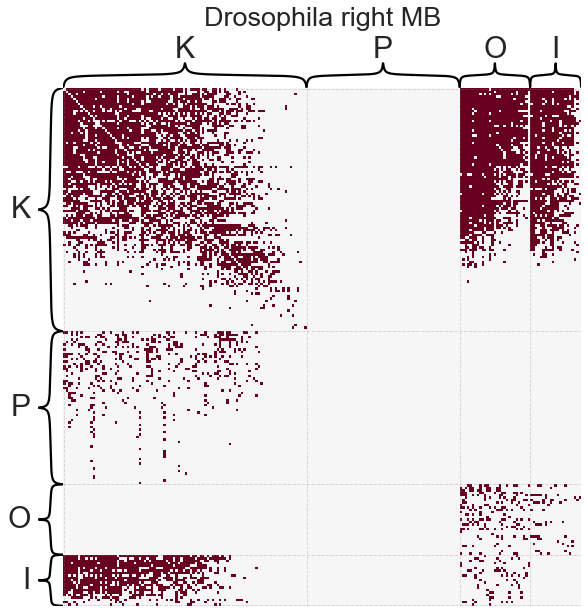

In [58]:
import numpy as np
from graspologic.datasets import load_drosophila_right
from graspologic.plot import heatmap
from graspologic.utils import binarize

adj, labels = load_drosophila_right(return_labels=True)
adj = binarize(adj)

degrees = adj.sum(axis=0) + adj.sum(axis=1)
sort_inds = np.argsort(-degrees)
adj = adj[sort_inds][:, sort_inds]
labels = labels[sort_inds]

_ = heatmap(
    adj,
    inner_hier_labels=labels,
    title="Drosophila right MB",
    font_scale=1.5,
    sort_nodes=False,
    cbar=False,
)

## Notation

$n$ - the number of nodes in the graph

$A$ - $n \times n$ adjacency matrix

$P$ - $n \times n$ matrix of probabilities

## Independent edge models

Many statistical network models fall under the umbrella of independent edge random networks, sometimes called the **Inhomogeneous Erdos-Renyi (IER)** model. Under this model, the elements of the network's adjacency matrix $A$ are sampled independently from a Bernoulli distribution:

$$A_{ij} \sim Bernoulli(P_{ij})$$

If $n$ is the number of nodes, the matrix $P$ is a $n \times n$ matrix of probabilities with elements in $[0, 1]$. Depending on how the matrix $P$ is constructed, we can create various different specific models. We next describe several of these choices. Note that for each model, we assume that there are no loops, or in other words the diagonal of the matrix $P$ will always be set to zero.



*For each graph model we will show:*
- how the model is formulated 
- how to fit the model using `graspologic`
- the $P$ matrix that was fit by the model 
- a single sample of a new network from the fit model

## Erdos-Reyni (ER)
The **Erdos-Reyni (ER)** model is the simplest random graph model. We are interested in modeling the probability of an edge existing between any two nodes, $i$ and $j$. We denote this probability $P_{ij}$. For the ER model:

$$P_{ij} = p$$

for any combination of $i$ and $j$.  
This means that the one parameter $p$ is the overall probability of connection for any two nodes. 

ER "p" parameter: 0.1661046088739007


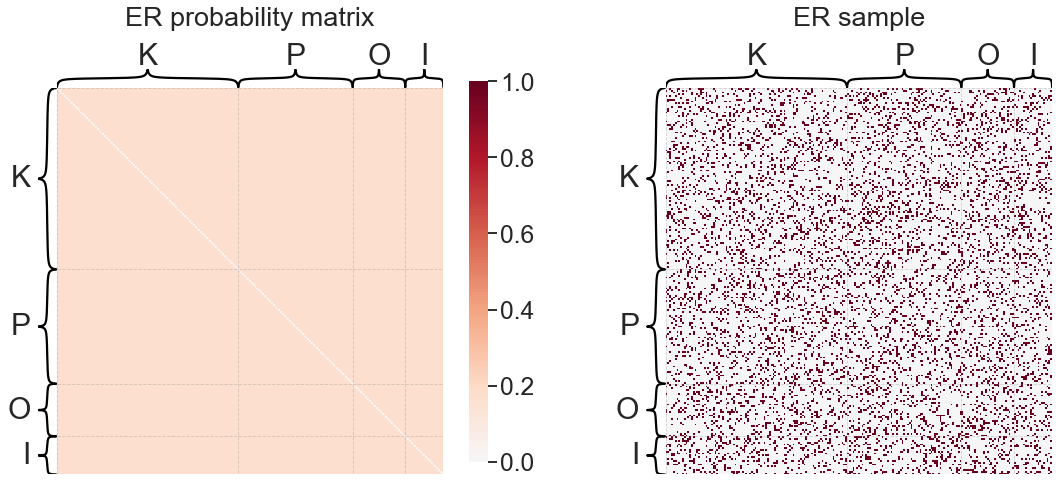

In [59]:
from graspologic.models import EREstimator

er = EREstimator(directed=True, loops=False)
er.fit(adj)
print(f'ER "p" parameter: {er.p_}')

def plot_model_and_sample(estimator, name):
    fig, axs = plt.subplots(1,2,figsize=(20,10), sharey=True)
    heatmap(
        estimator.p_mat_,
        inner_hier_labels=labels,
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title=f"{name} probability matrix",
        sort_nodes=False,
        ax=axs[0]
    )
    ax = heatmap(
        estimator.sample()[0],
        inner_hier_labels=labels,
        font_scale=1.5,
        title=f"{name} sample",
        sort_nodes=False,
        ax=axs[1],
    )
    fig.axes[5].remove()

plot_model_and_sample(er, 'ER')

## Degree-corrected Erdos-Reyni (DCER)

A slightly more complicated variant of the ER model is the **degree-corrected Erdos-Reyni model (DCER)**. Here, there is still a global parameter $p$ to specify relative connection probability between all edges. However, we add a promiscuity parameter $\theta_i$ for each node $i$ which specifies its expected degree relative to other nodes:

$$P_{ij} = \theta_i \theta_j p$$

so the probability of an edge from $i$ to $j$ is a function of the two nodes' degree-correction parameters, and the overall probability of an edge in the graph. 

```{note}
There is a commonly used network model called the **configuration model** which exactly
specifies the degree sequence, and is usually sampled somewhat differently. We use the 
DCER term for consistency with the rest of these models, but note that this is very
similar in spirit to a configuration model.
```

```{note}
This model has what is called a **nonidentifiability** this can be thought of as having
some flexibility in the model parameters which has no effect on the model itself. We 
could multiply $p$ by 2, and divide the vector $\theta$ by 2, and have the same matrix 
$P$. As an aside, nonidentifiabilities are important to consider when comparing 
parameters. Here, we just use the convention that $\theta$ sum to 1, which gives $p$ the
interpretation as the expected number of edges.
```

DCER "p" parameter: 7536.0


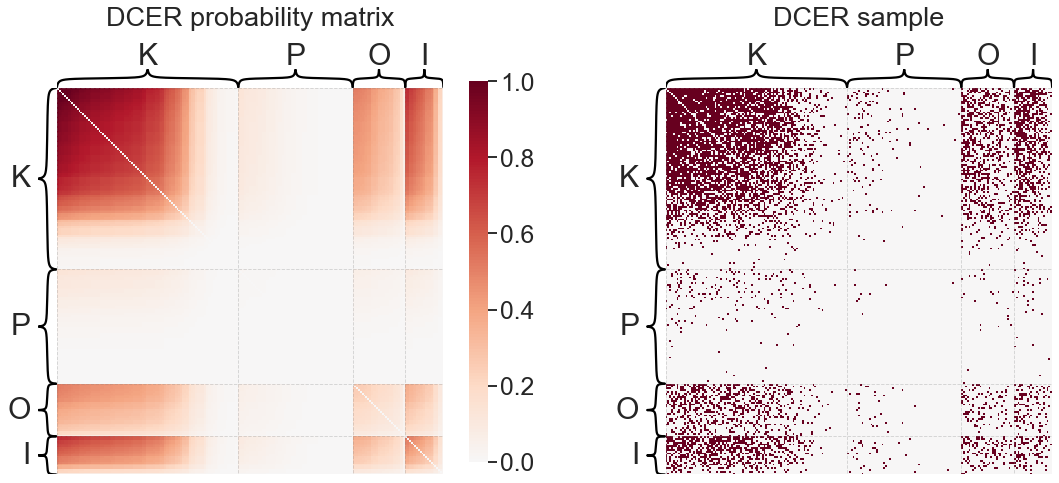

In [60]:
from graspologic.models import DCEREstimator

dcer = DCEREstimator(directed=True, loops=False)
dcer.fit(adj)
print(f'DCER "p" parameter: {dcer.p_}')

plot_model_and_sample(dcer, 'DCER')

## Stochastic block model (SBM)
Under the **stochastic block model (SBM)**, each node is modeled as belonging to a block (sometimes called a community or group). The probability of node $i$ connecting to node $j$ is simply a function of the block membership of the two nodes. Let $n$ be the number of nodes in the graph, then $\tau$ is a length $n$ vector which indicates the block membership of each node in the graph. Let $K$ be the number of blocks, then $B$ is a $K \times K$ matrix of block-block connection probabilities. 

$$P_{ij} = B_{\tau_i \tau_j}$$

SBM "B" matrix:
[[0.         0.38333333 0.11986864 0.        ]
 [0.44571429 0.3584     0.49448276 0.        ]
 [0.09359606 0.         0.20095125 0.        ]
 [0.         0.07587302 0.         0.        ]]


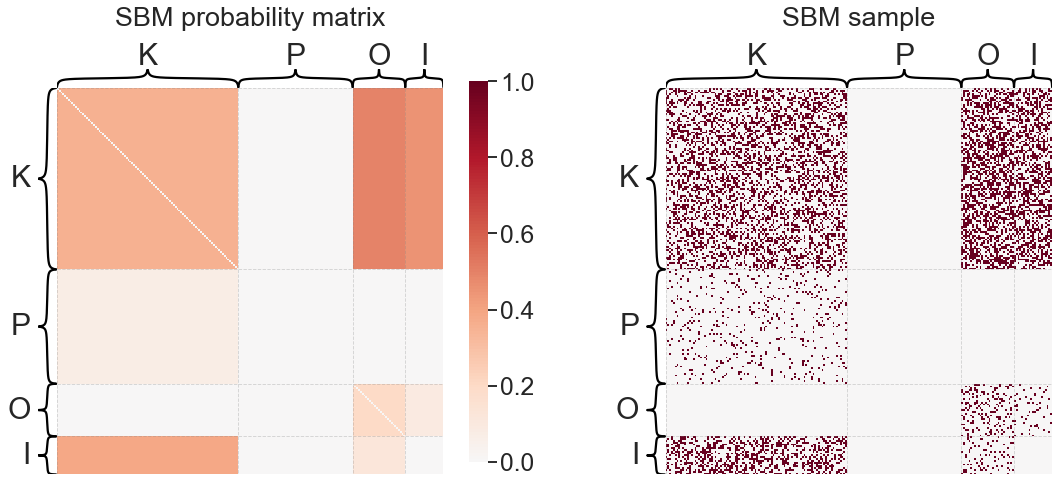

In [61]:
from graspologic.models import SBMEstimator

sbme = SBMEstimator(directed=True, loops=False)
sbme.fit(adj, y=labels)
print('SBM "B" matrix:')
print(sbme.block_p_)

plot_model_and_sample(sbme, 'SBM')

## Degree-corrected stochastic block model (DCSBM)
Just as we could add a degree-correction term to the ER model, so too can we modify the stochastic block model to allow for heterogeneous expected degrees. This yields the **degree-corrected stochastic block model.** Again, we let $\theta$ be a length $n$ vector of degree correction parameters, and all other parameters remain as they were defined above for the SBM: 

$$P_{ij} = \theta_i \theta_j B_{\tau_i, \tau_j}$$

Note that the matrix $B$ may no longer represent true probabilities, because the addition of the $\theta$ vectors introduces a multiplicative constant that can be absorbed into the elements of $\theta$.

DCSBM "B" matrix:
[[   0.  805.   73.    0.]
 [ 936. 3584. 1434.    0.]
 [  57.    0.  169.    0.]
 [   0.  478.    0.    0.]]


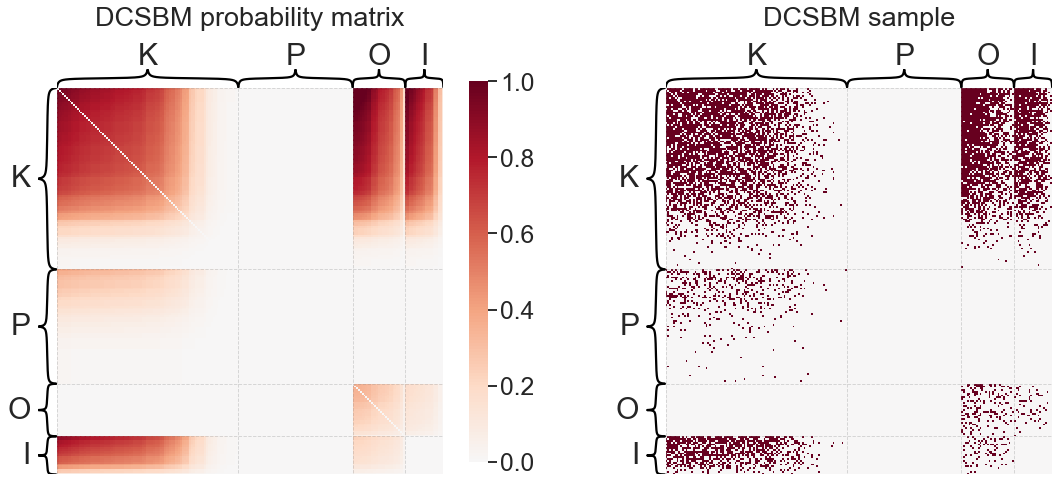

In [62]:
from graspologic.models import DCSBMEstimator

dcsbme = DCSBMEstimator(directed=True, loops=False)
dcsbme.fit(adj, y=labels)
print('DCSBM "B" matrix:')
print(dcsbme.block_p_)

plot_model_and_sample(dcsbme, 'DCSBM')

## Random dot product graph (RDPG)

The random dot product graph model (RDPG) {cite}`athreya2017statistical, young2007random` is a (relatively speaking) newer network model under the umbrella of latent position random graphs \cite{hoff2002latent}. Under latent position models, each node has an associated, typically unobserved vector which is referred to as the \textbf{latent position} of that node. For the directed network case, we can allow each node to have associated "in" and "out" latent position vectors which may not be the same, with the former governing the nodes inputs and the latter governing its outputs. If $x_i$ is the out latent position for node $i$, and $y_j$ the input latent position for node $j$, then the probability of an edge between $i$ and $j$ is some function of these vectors:
$$P[A_{ij} = 1] = P_{ij} = f(x_i, y_j)$$
More specifically for the RDPG, the link function $f$ is the dot product:
$$P[A_{ij} = 1] = P_{ij} = \langle x_i, y_j \rangle$$
The latent positions are thus restricted such that $\langle x_i, y_j \rangle \in [0, 1]$ for all $(i,j)$ pairs. Under this definition, $P$, the matrix of connection probabilities, can be written as $P = XY^T$, where $X \in \mathbb{R}^{n \times d}$ is a matrix where each row $i$ is the out latent position of node $i$, and likewise for $Y$ and the in latent positions.

In practical applications, we never observe the latent positions in $X$ and $Y$ - they must be estimated from the observed network, $A$. Fortunately, this can be done via an established technique known as \textbf{adjacency spectral embedding (ASE)} \cite{athreya2017statistical}, which was recently shown to be a consistent estimator of these latent positions.

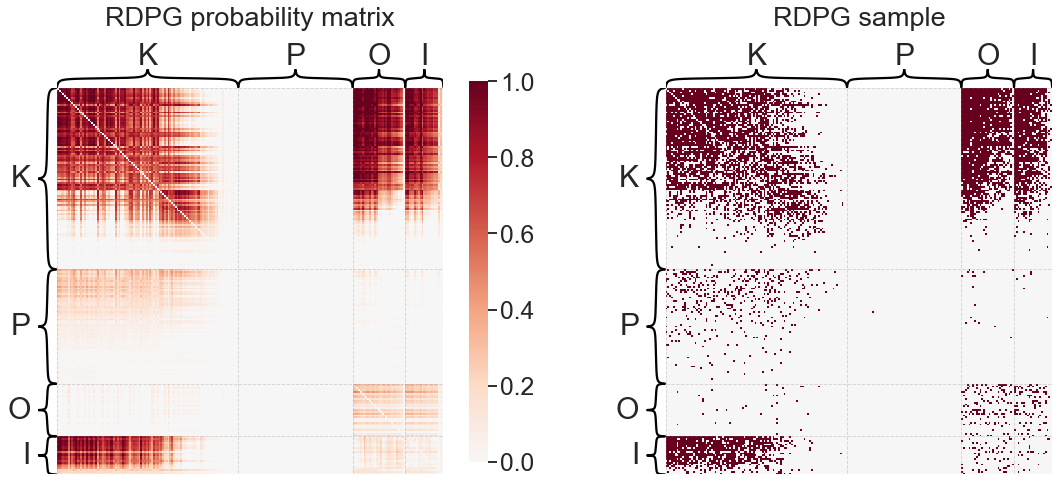

In [63]:
from graspologic.models import RDPGEstimator

rdpge = RDPGEstimator(loops=False)
rdpge.fit(adj, y=labels)

plot_model_and_sample(rdpge, 'RDPG')

For the RDPG, looking at the model parameters can be more challenging, since in this
case they are a $d$-dimensional vector for each node. 

In [71]:
rdpge.latent_[0].shape

(213, 3)

## Compare all of the models on this dataset

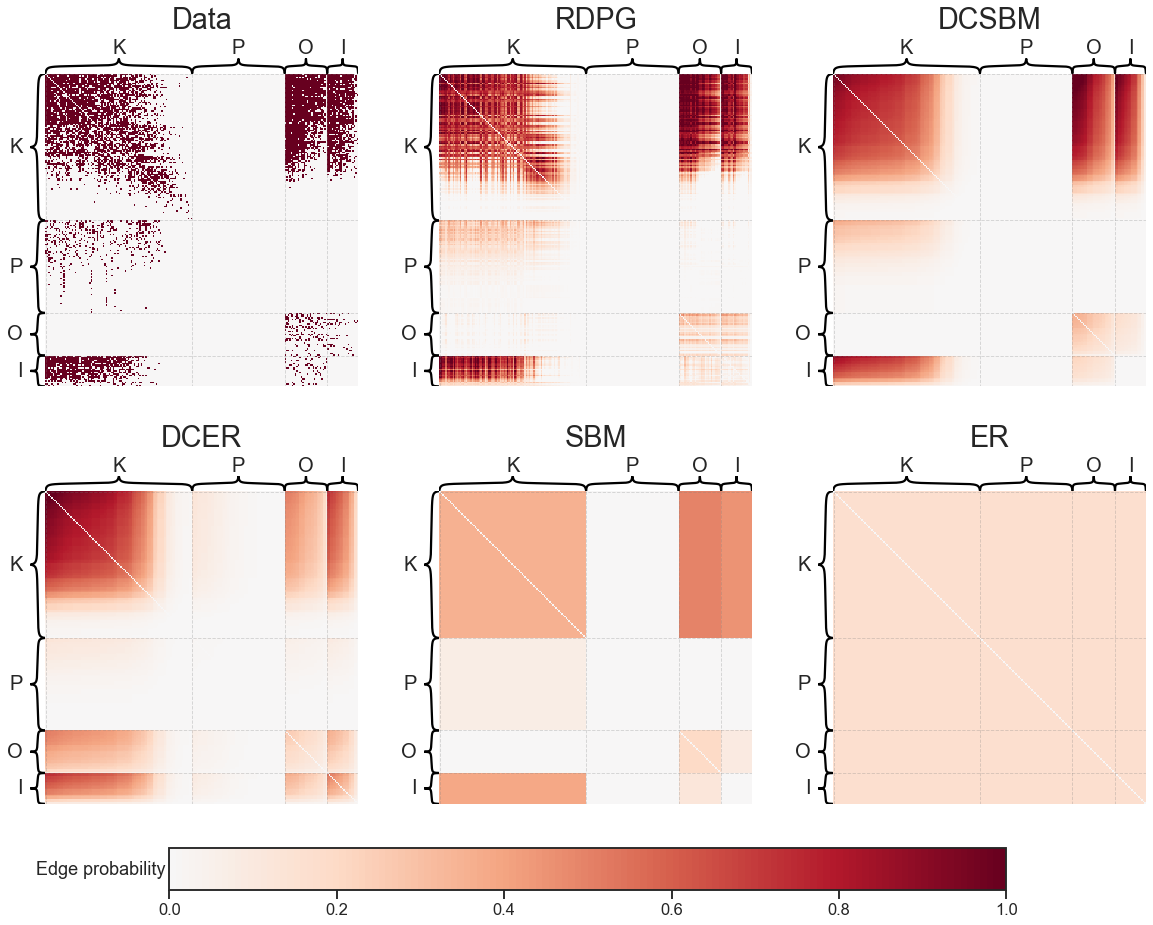

In [30]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

fig, axs = plt.subplots(2, 3, figsize=(20, 16))

sns.set_context('talk')
# colormapping
cmap = cm.get_cmap("RdBu_r")

center = 0
vmin = 0
vmax = 1
norm = mpl.colors.Normalize(0, 1)
cc = np.linspace(0.5, 1, 256)
cmap = mpl.colors.ListedColormap(cmap(cc))

# heatmapping
heatmap_kws = dict(
    inner_hier_labels=labels,
    vmin=0,
    vmax=1,
    cbar=False,
    cmap=cmap,
    center=None,
    hier_label_fontsize=20,
    title_pad=45,
    font_scale=1.6,
    sort_nodes=True,
)

models = [rdpge, dcsbme, dcer, sbme, er]
model_names = ["RDPG", "DCSBM", "DCER", "SBM", "ER"]

heatmap(adj, ax=axs[0][0], title="Data", **heatmap_kws)
heatmap(models[0].p_mat_, ax=axs[0][1], title=model_names[0], **heatmap_kws)
heatmap(models[1].p_mat_, ax=axs[0][2], title=model_names[1], **heatmap_kws)
heatmap(models[2].p_mat_, ax=axs[1][0], title=model_names[2], **heatmap_kws)
heatmap(models[3].p_mat_, ax=axs[1][1], title=model_names[3], **heatmap_kws)
heatmap(models[4].p_mat_, ax=axs[1][2], title=model_names[4], **heatmap_kws)


# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(dcsbme.p_mat_)
cbar = fig.colorbar(
    sm,
    ax=axs,
    orientation="horizontal",
    pad=0.04,
    shrink=0.75,
    fraction=0.08,
    drawedges=False,
)

cbar.ax.set_ylabel('Edge probability', rotation=0, ha='right', va='center')
cbar.ax.yaxis.set_visible(True)


## Relationships among these models

```{figure} ./images/model-relationships.png
---
name: model-relationships
---
Relationships among independent edge models (some not mentioned here). Figure from 
{cite:t}`chung2021statistical`. 
```

```{admonition} Question
:class: tip

When can an SBM also be considered an ER model?

```

```{admonition} Question
:class: tip

When can an SBM be considered a DCSBM?

```

```{admonition} Question
:class: tip

When can an RDPG be considered a SBM?

```

```{admonition} Question
:class: tip

When can an RDPG be considered a DCSBM?

Hint: have a look at the last plot in [this notebook](https://docs.neurodata.io/notebooks/pedigo/graspologic/2020/09/24/latent_model_tutorial.html).

```